## Nhận dạng ký tự trong biển xe bằng CNN

In [52]:
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint


### Đọc dữ liệu từ tập dataset
Thư mục character_dataset
Sử dụng lớp ImageDataGenerator:
- rescale: giảm giá trị dữ liệu (ảnh RGB [0,255]) về [0,1] để xử lý dễ dàng.
- width_shift_range, height_shift_range được sử dụng để tạo thêm dữ liệu cho bộ huấn luyện. Giá trị float: ảnh được dịch sang trái/phải (width) hoặc lên/xuống (height) một khoảng gia_tri_float*kich_thuoc_anh.
- resize các ảnh về 28x28.

In [53]:
dataset = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1)

path = 'character_dataset'

train = dataset.flow_from_directory(
    path+'/train',  # đường dẫn thư mục
    target_size=(28, 28),  # resize các ảnh về 28x28
    batch_size=1,  # kích thước lô dữ liệu
    class_mode='categorical')

validation = dataset.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical')


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


### Khởi tạo mô hình CNN
Mô hình sẽ gồm các layers:
- 4 convolutional với hàm kích hoạt là 'relu'
- MaxPooling với kích thước cửa số 4x4. MaxPooling là một quá trình tùy biến dựa trên mẫu. Mục tiêu là rút gọn mẫu biểu diễn đầu vào, giảm kích thước của nó và cho phép đưa ra các giả định về các đối tượng địa lý chứa trong các vùng con được phân loại.
- Dropout: thêm một số tỷ lệ bỏ học để tránh overfitting. Dropout là một siêu thông số chính quy được khởi tạo để ngăn Neural Network bị overfitting. Chọn dropout=0,4 có nghĩa là 60% nút sẽ được giữ lại.
- Flatten: lớp làm phẳng dữ liệu nút. Lớp làm phẳng lấy dữ liệu từ lớp trước và thể hiện nó trong một chiều duy nhất.
- 2 lớp Dense: output 36 lớp (26 chữ cái + 10 chữ số) với hàm kích hoạt là 'softmax' (do là bài toán phân loại nhiều lớp)

Tối ưu các tham số bằng cách sử dụng Grid Search
- dropout rate: 0.2, 0.4
- learning rate: 0.001, 0.0005, 0.0001 với trình tối ưu optimizer: adam, sgd, rmsprop

In [54]:
K.clear_session()
model = Sequential() # tạo 1 lớp tuần tự
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])


In [55]:
# tóm tắt cấu trúc mạng
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)              0         
__________

# Huấn luyện mô hình

``` batch_size = 1 ``` và ``` step_per_epoch = train.samples // batch_size ``` để đảm bảo sẽ sử dụng tất cả dữ liệu tập train trong 1 epoch

In [56]:
mc = ModelCheckpoint('weights/model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

batch_size = 1
result = model.fit_generator(
    train,
    steps_per_epoch=train.samples // batch_size,
    validation_data=validation,
    validation_steps=validation.samples // batch_size,
    epochs=30, verbose=1, callbacks=[mc])


Epoch 1/30
864/864 [==============================] - 51s 59ms/step - loss: 3.1586 - acc: 0.1655 - val_loss: 1.9083 - val_acc: 0.5185

Epoch 00001: val_acc improved from -inf to 0.51852, saving model to weights/model.h5
Epoch 2/30
864/864 [==============================] - 54s 62ms/step - loss: 1.2364 - acc: 0.6308 - val_loss: 0.6979 - val_acc: 0.8102

Epoch 00002: val_acc improved from 0.51852 to 0.81019, saving model to weights/model.h5
Epoch 3/30
864/864 [==============================] - 46s 53ms/step - loss: 0.6465 - acc: 0.7940 - val_loss: 0.3934 - val_acc: 0.8843

Epoch 00003: val_acc improved from 0.81019 to 0.88426, saving model to weights/model.h5
Epoch 4/30
864/864 [==============================] - 45s 52ms/step - loss: 0.4128 - acc: 0.8669 - val_loss: 0.2341 - val_acc: 0.9398

Epoch 00004: val_acc improved from 0.88426 to 0.93981, saving model to weights/model.h5
Epoch 5/30
864/864 [==============================] - 47s 54ms/step - loss: 0.2715 - acc: 0.9132 - val_loss: 0.

### Vẽ đồ thị kết quả quá trình training

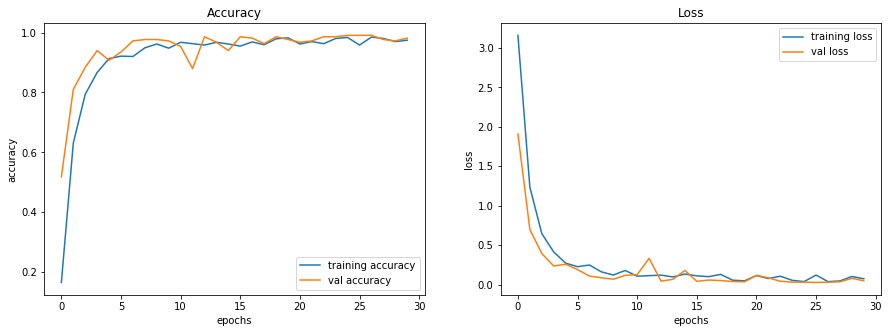

In [57]:
# Vẽ đồ thị kết quả training
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
grid = GridSpec(ncols=2, nrows=1, figure=fig)

fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


### Thử nghiệm các mô hình khác

In [1]:
"""
Thử nghiệm cho model2
"""

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint

dataset = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1)

path = 'character_dataset'

train = dataset.flow_from_directory(
    path+'/train',  # đường dẫn thư mục
    target_size=(28, 28),  # resize các ảnh về 28x28
    batch_size=1,  # kích thước lô dữ liệu
    class_mode='categorical')

validation = dataset.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical')

K.clear_session()
model = Sequential() # tạo 1 lớp tuần tự
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

model.summary()

mc = ModelCheckpoint('weights/model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Using TensorFlow backend.


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
ma

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
864/864 [==============================] - 12s 14ms/step - loss: 3.0429 - acc: 0.1759 - val_loss: 1.5437 - val_acc: 0.5833

Epoch 00001: val_acc improved from -inf to 0.58333, saving model to weights/model2.h5
Epoch 2/30
864/864 [==============================] - 14s 16ms/step - loss: 1.0796 - acc: 0.6713 - val_loss: 0.5671 - val_acc: 0.8287

Epoch 00002: val_acc improved from 0.58333 to 0.82870, saving model to weights/model2.h5
Epoch 3/30
864/864 [==============================] - 13s 16ms/step - loss: 0.5381 - acc: 0.8322 - val_loss: 0.3841 - val_acc: 0.8843

Epoch 00003: val_acc improved from 0.82870 to 0.88426, saving model to weights/model2.h5
Epoch 4/30
864/864 [==============================] - 13s 15ms/step - loss: 0.4242 - acc: 0.8646 - val_loss: 0.2737 - val_acc: 0.9352

Epoch 00004: val_acc improved from 0.88426 to 0.93519, saving model to weights/model2.h5
Epoch 5/30
86

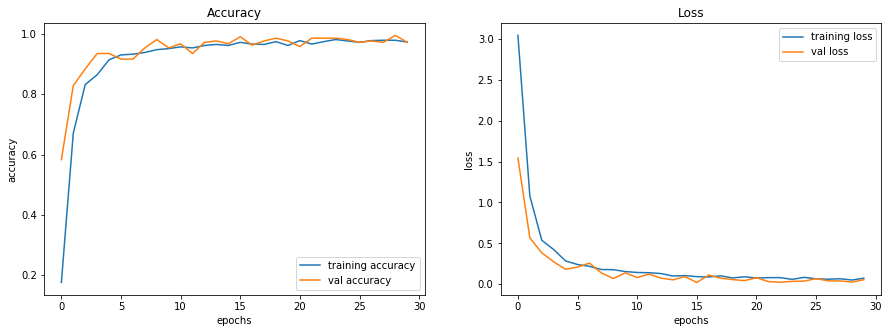

In [2]:
batch_size = 1
result = model.fit_generator(
      train,
      steps_per_epoch = train.samples // batch_size,
      validation_data = validation, 
      validation_steps = validation.samples // batch_size,
      epochs = 30, callbacks=[mc])

# Vẽ đồ thị kết quả training
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
grid = GridSpec(ncols=2, nrows=1, figure=fig)

fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


In [60]:
"""
Sử dụng model 3
"""

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint

dataset = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1)

path = 'character_dataset'

train = dataset.flow_from_directory(
    path+'/train',  # đường dẫn thư mục
    target_size=(28, 28),  # resize các ảnh về 28x28
    batch_size=1,  # kích thước lô dữ liệu
    class_mode='categorical')

validation = dataset.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical')

K.clear_session()
model = Sequential() # tạo 1 lớp tuần tự
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

model.summary()

mc = ModelCheckpoint('weights/model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3136)              0         
__________________________________________________________

Epoch 1/30
864/864 [==============================] - 15s 18ms/step - loss: 3.1319 - acc: 0.1852 - val_loss: 1.8368 - val_acc: 0.5231

Epoch 00001: val_acc improved from -inf to 0.52315, saving model to weights/model3.h5
Epoch 2/30
864/864 [==============================] - 14s 16ms/step - loss: 1.2535 - acc: 0.6169 - val_loss: 0.8205 - val_acc: 0.7500

Epoch 00002: val_acc improved from 0.52315 to 0.75000, saving model to weights/model3.h5
Epoch 3/30
864/864 [==============================] - 12s 14ms/step - loss: 0.6987 - acc: 0.7778 - val_loss: 0.4865 - val_acc: 0.8519

Epoch 00003: val_acc improved from 0.75000 to 0.85185, saving model to weights/model3.h5
Epoch 4/30
864/864 [==============================] - 15s 17ms/step - loss: 0.4695 - acc: 0.8600 - val_loss: 0.3017 - val_acc: 0.9213

Epoch 00004: val_acc improved from 0.85185 to 0.92130, saving model to weights/model3.h5
Epoch 5/30
864/864 [==============================] - 15s 18ms/step - loss: 0.4036 - acc: 0.8669 - val_loss

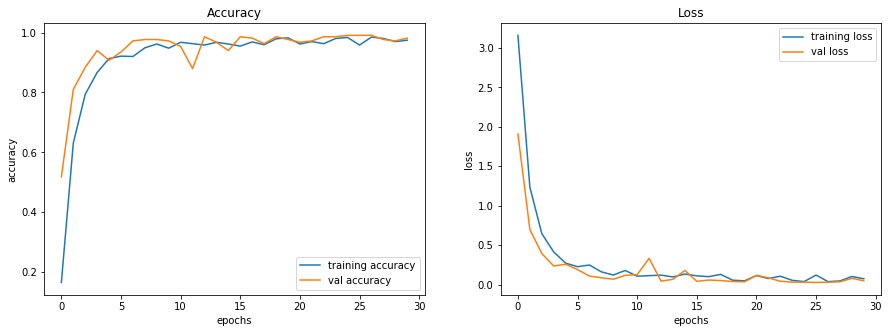

In [61]:
batch_size = 1
result = model.fit_generator(
      train,
      steps_per_epoch = train.samples // batch_size,
      validation_data = validation, 
      validation_steps = validation.samples // batch_size,
      epochs = 30, callbacks=[mc])

# Vẽ đồ thị kết quả training
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
grid = GridSpec(ncols=2, nrows=1, figure=fig)

fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()